# European heat wave SST composites - upstream analysis



## 1. Load Python libraries

In [2]:
import numpy as np
from numpy import *
import bisect
import scipy as sp
from scipy.stats import gaussian_kde, ttest_ind
import numpy.matlib 
import math
from scipy import signal
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from datetime import datetime, timedelta
import matplotlib.animation as animation
from matplotlib import rc
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.rasterize_and_save as raster


## 2. Load data sets 

In [3]:
ds_ERA5_SST = xr.open_dataset('/data/user/jukrueger/ERA5/daily/ERA5__sea_surface_temperature__1979-2019.nc')
ds_ERA5_z = xr.open_dataset('/data/user/jukrueger/ERA5/daily/ERA5__z300hPa__1979-2019.nc')
ds_ERA5_T2M = xr.open_dataset('/data/user/jukrueger/ERA5/daily/ERA5__2m_temperature__1979-2019.nc')
ds_ERA5_SST_old = xr.open_dataset('/data/user/jukrueger/ERA5/daily/ERA5__sea_surface_temperature__1979-2019.nc')
ds_ERA5_lathf = xr.open_dataset('/data/user/jukrueger/ERA5/daily/ERA5__surface_latent_heat_flux__1979-2019.nc')
ds_ERA5_senhf = xr.open_dataset('/data/user/jukrueger/ERA5/daily/ERA5__surface_sensible_heat_flux__1979-2019.nc')
ds_ERA5_tcc = xr.open_dataset('/data/user/jukrueger/ERA5/ERA5_total_cloud_cover_1979_2019.nc')
ds_ERA5_snsr = xr.open_dataset('/data/user/jukrueger/ERA5/ERA5_surface_net_solar_radiation_1979_2019.nc')
ds_ERA5_sntr = xr.open_dataset('/data/user/jukrueger/ERA5/ERA5_surface_net_thermal_radiation_1979_2019.nc')
ds_ERA5_z_PW_RWP = xr.open_dataset('/data/user/jukrueger/ERA5/daily/ERA5_300hPa_z_1979-2019__filtered-PW-RWP.nc')
ds_downstream_analysis = xr.open_dataset('/home/jukrueger/jupyter_notebooks/sst_anomaly_heatwaves/ERA5_downstream_analysis_composite_12dates.nc')
ds_downstream_analysis_warm_comp = xr.open_dataset('/home/jukrueger/jupyter_notebooks/sst_anomaly_heatwaves/ERA5_downstream_analysis_composite_dates_warm_composite.nc')

In [4]:
print(ds_ERA5_z_PW_RWP.filt_RWP)
print(ds_ERA5_z_PW_RWP.filt_PW)
print(ds_downstream_analysis)
print(ds_downstream_analysis_warm_comp)

<xarray.DataArray 'filt_RWP' (time: 14975, latitude: 73, longitude: 144)>
[157417200 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01T06:00:00 ... 2019-12-31T06:00:00
  * longitude  (longitude) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * latitude   (latitude) float64 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
Attributes:
    long_name:     w4-15 components of geopotential fields
    units:         anomalies in m**2 s**-2
    cell_methods:  time: mean
<xarray.DataArray 'filt_PW' (time: 14975, latitude: 73, longitude: 144)>
[157417200 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01T06:00:00 ... 2019-12-31T06:00:00
  * longitude  (longitude) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * latitude   (latitude) float64 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
Attributes:
    long_name:     w1-3 components of geopotential fields
    units:         anomalies in m**2 s**-2
    cell_methods:  tim

## 3. T2M for composite dates calculation

* Deseasonalize
* Calc mean of European box
* Select only JJA values
* add 'year' coordinate for composite calculation later
* Calc quantiles

In [5]:
##### Deseasonalize SST data: Subtract difference between the means of each day and the whole time mean
sst_deseason = ds_ERA5_SST.var34.groupby("time.dayofyear") - (ds_ERA5_SST.var34.groupby("time.dayofyear").mean("time", skipna=False) - ds_ERA5_SST.var34.mean('time', skipna=False))
t2m_deseason = ds_ERA5_T2M.var167.groupby("time.dayofyear") - (ds_ERA5_T2M.var167.groupby("time.dayofyear").mean("time") - ds_ERA5_T2M.var167.mean('time'))

########## Calculation for SST and T2M Map ###########
##### Connect SSt and T2M
sst_t2m = ds_ERA5_SST_old.var34.where(ds_ERA5_SST_old.var34 >= -8.999999873090293e+33, ds_ERA5_T2M.var167)
##### Deseasonalize SST data: Subtract difference between the means of each day and the whole time mean
sst_t2m_deseason = sst_t2m.groupby("time.dayofyear") - (sst_t2m.groupby("time.dayofyear").mean("time") - sst_t2m.mean('time'))
# Detrend data set 
sst_t2m_detrend = signal.detrend(sst_t2m_deseason, axis=0)
# Produce xarray Data Array
sst_t2m_detrend_xr =  xr.DataArray(data=sst_t2m_detrend, dims=["time", "lat", "lon"], coords=dict(lon = ds_ERA5_SST.lon,lat= ds_ERA5_SST.lat, time=ds_ERA5_SST.time))                                                                                               
# Calc climatology
sst_t2m_detrend_clim = sst_t2m_detrend_xr.groupby('time.season').mean('time')
# Calc detrended JJA anomalies
sst_t2m_JJA_anom = sst_t2m_detrend_xr.resample(time="QS-DEC").mean()[2::4] - sst_t2m_detrend_clim.sel(season='JJA')
# ...only for 2018
years = [str(int(n)) for n in np.linspace(1979,2019,41)]
sst_t2m_detrend_xr_append=[]
for i in range(41):
    sst_t2m_detrend_xr_append.append(sst_t2m_detrend_xr.sel(time=slice(years[i]+'-07-12 11:30:00', years[i]+'-08-08 11:30:00')))

sst_t2m_detrend_xr_concat= xr.concat(sst_t2m_detrend_xr_append,dim='time').mean('time')
print(sst_t2m_detrend_xr_concat)
sst_t2m_2018_JJA_anom = sst_t2m_detrend_xr.sel(time=slice('2018-07-12 11:30:00','2018-08-08 11:30:00')).mean('time') - sst_t2m_detrend_xr_concat
######################################################


##### Calc North Atlantic weighted mean over 45-60°N / 15-40°W:
weights = np.cos(np.deg2rad(ds_ERA5_SST.lat))
sst_Atl = sst_deseason.sel(lon=slice(320.0, 345.0), lat=slice(60.0, 45.0)).weighted(weights).mean('lon').mean('lat')
t2m_Euro = t2m_deseason.sel(lon=slice(0, 20.0), lat=slice(52.5, 45.0)).weighted(weights).mean('lon').mean('lat')
print(t2m_Euro)
t2m_Euro =  xr.DataArray(data=t2m_Euro, dims=["time"], coords=dict( time=ds_ERA5_SST.time))                                                                                               
print(t2m_Euro)

#############################
# Detrend data set 
sst_Atl_ds_dt = signal.detrend(sst_Atl, axis=0)
t2m_Euro_ds_dt = signal.detrend(t2m_Euro, axis=0)

# Produce xarray Data Array
sst_Atl_ds_dt_xr =  xr.DataArray(data=sst_Atl_ds_dt, dims=["time"], coords=dict(time=ds_ERA5_SST.time)) 
t2m_Euro_ds_dt_xr =  xr.DataArray(data=t2m_Euro_ds_dt, dims=["time"], coords=dict(time=t2m_Euro.time)) 
#############################

##### Select only JJA values
sst_deseason_Atl_JJA = sst_Atl_ds_dt_xr.sel(time=sst_Atl['time.season']==['JJA'])
t2m_deseason_Euro_JJA = t2m_Euro_ds_dt_xr.sel(time=t2m_Euro['time.season']==['JJA'])#.rolling(time=7, center=True).mean().dropna("time")
t2m_deseason_Euro_JJA_wrm = t2m_Euro_ds_dt_xr.sel(time=t2m_Euro['time.season']==['JJA'])
sst_deseason_Atl_JJA_mean = sst_deseason_Atl_JJA.resample(time="QS-DEC").mean().dropna(dim='time')# - sst_Atl.mean('time')
t2m_deseason_Euro_JJA_mean = t2m_deseason_Euro_JJA.resample(time="QS-DEC").mean().dropna(dim='time')# - t2m_Euro.mean('time')

print(t2m_deseason_Euro_JJA)
print(t2m_deseason_Euro_JJA_mean)

##### Add coordinate 'Year' to the data set 
A=xr.DataArray(np.full((92), 1979))
years=[]
for i in range(len(t2m_deseason_Euro_JJA_mean)):
    years.append(A)
    A=A+1
years_array = xr.concat(years, dim='dim_0')
#years_array=years_array[3:-3]
t2m_deseason_Euro_JJA = t2m_deseason_Euro_JJA.assign_coords(year=('time',years_array))
print(years_array)
print(t2m_deseason_Euro_JJA)

##### Calc quantiles
quantile_10 = t2m_deseason_Euro_JJA.quantile(0.1, dim='time')
quantile_25 = t2m_deseason_Euro_JJA.quantile(0.25, dim='time')
quantile_40 = t2m_deseason_Euro_JJA.quantile(0.4, dim='time')
quantile_60 = t2m_deseason_Euro_JJA.quantile(0.6, dim='time')
quantile_75 = t2m_deseason_Euro_JJA.quantile(0.75, dim='time')
quantile_90 = t2m_deseason_Euro_JJA.quantile(0.95, dim='time')
print(quantile_90)

<xarray.DataArray (lat: 73, lon: 144)>
array([[ 1.0696314e-05,  1.0696314e-05,  1.0696314e-05, ...,
         1.0696314e-05,  1.0696314e-05,  1.0696314e-05],
       [ 1.0696314e-05,  1.0696314e-05,  1.0696314e-05, ...,
        -1.3039579e-05,  2.9387298e-05,  2.9387298e-05],
       [ 1.0696314e-05,  1.0696314e-05,  1.0696314e-05, ...,
        -1.1302806e-05,  3.1813266e-05,  1.0448204e-05],
       ...,
       [ 1.8338032e-02,  1.8680645e-02,  1.9195681e-02, ...,
         1.9640984e-02,  1.9068828e-02,  1.8560780e-02],
       [ 2.8414181e-02,  2.8591650e-02,  2.8763356e-02, ...,
         2.8060762e-02,  2.8198944e-02,  2.8310457e-02],
       [ 3.0644115e-02,  3.0644115e-02,  3.0644115e-02, ...,
         3.0644115e-02,  3.0644115e-02,  3.0644115e-02]], dtype=float32)
Coordinates:
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float64 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
<xarray.DataArray (time: 14975)>
array([274.93165588, 27

*  Composite criteria
 * Only one event at maximum for each composite per year and
 * date has to be the start of a cold, medium or warm period and 
 * the 4 following days are above or below the same quantile threshold as well

In [6]:
t2m_deseason_Euro_JJA_lag0_10=[]
t2m_deseason_Euro_JJA_lag0_25=[]
t2m_deseason_Euro_JJA_lag0_40_60=[]
t2m_deseason_Euro_JJA_lag0_75=[]
t2m_deseason_Euro_JJA_lag0_90=[]

for i in range(0, len(t2m_deseason_Euro_JJA)-5):
    j=np.array([i, i+1, i+2])
    if np.all(t2m_deseason_Euro_JJA[j] < quantile_10) and t2m_deseason_Euro_JJA[i-1] > quantile_10 and t2m_deseason_Euro_JJA[i-1].time.year == t2m_deseason_Euro_JJA[i].time.year and t2m_deseason_Euro_JJA[i+2].time.year == t2m_deseason_Euro_JJA[i].time.year: 
        if t2m_deseason_Euro_JJA_lag0_10 == []:  
            t2m_deseason_Euro_JJA_lag0_10.append(t2m_deseason_Euro_JJA[i])
        elif t2m_deseason_Euro_JJA_lag0_10[-1].time < (t2m_deseason_Euro_JJA[i].time - pd.Timedelta("30 days")):
            t2m_deseason_Euro_JJA_lag0_10.append(t2m_deseason_Euro_JJA[i])

    if np.all(t2m_deseason_Euro_JJA[j] < quantile_25) and t2m_deseason_Euro_JJA[i-1] > quantile_25 and t2m_deseason_Euro_JJA[i-1].time.year == t2m_deseason_Euro_JJA[i].time.year and t2m_deseason_Euro_JJA[i+2].time.year == t2m_deseason_Euro_JJA[i].time.year:
        if t2m_deseason_Euro_JJA_lag0_25 == []:  
            t2m_deseason_Euro_JJA_lag0_25.append(t2m_deseason_Euro_JJA[i])
        elif t2m_deseason_Euro_JJA_lag0_25[-1].time < (t2m_deseason_Euro_JJA[i].time - pd.Timedelta("30 days")):
            t2m_deseason_Euro_JJA_lag0_25.append(t2m_deseason_Euro_JJA[i])
        
    if np.all(t2m_deseason_Euro_JJA[j] > quantile_40) and np.all(t2m_deseason_Euro_JJA[j] < quantile_60) and (t2m_deseason_Euro_JJA[i-1] < quantile_40 or t2m_deseason_Euro_JJA[i-1] > quantile_60) and t2m_deseason_Euro_JJA[i-1].time.year == t2m_deseason_Euro_JJA[i].time.year and t2m_deseason_Euro_JJA[i+5].time.year == t2m_deseason_Euro_JJA[i].time.year:
        if t2m_deseason_Euro_JJA_lag0_40_60 == []:  
            t2m_deseason_Euro_JJA_lag0_40_60.append(t2m_deseason_Euro_JJA[i])
        elif t2m_deseason_Euro_JJA_lag0_40_60[-1].time < (t2m_deseason_Euro_JJA[i].time - pd.Timedelta("30 days")):
            t2m_deseason_Euro_JJA_lag0_40_60.append(t2m_deseason_Euro_JJA[i])

    if np.all(t2m_deseason_Euro_JJA[j] > quantile_75) and t2m_deseason_Euro_JJA[i-1] < quantile_75 and t2m_deseason_Euro_JJA[i-1].time.year == t2m_deseason_Euro_JJA[i].time.year and t2m_deseason_Euro_JJA[i+2].time.year == t2m_deseason_Euro_JJA[i].time.year:
        if t2m_deseason_Euro_JJA_lag0_75 == []:  
            t2m_deseason_Euro_JJA_lag0_75.append(t2m_deseason_Euro_JJA[i])
        elif t2m_deseason_Euro_JJA_lag0_75[-1].time < (t2m_deseason_Euro_JJA[i].time - pd.Timedelta("30 days")):
            t2m_deseason_Euro_JJA_lag0_75.append(t2m_deseason_Euro_JJA[i])
        
    if np.all(t2m_deseason_Euro_JJA[j] > quantile_90) and t2m_deseason_Euro_JJA[i-1] < quantile_90 and t2m_deseason_Euro_JJA[i-1].time.year == t2m_deseason_Euro_JJA[i].time.year and t2m_deseason_Euro_JJA[i+2].time.year == t2m_deseason_Euro_JJA[i].time.year:
        if t2m_deseason_Euro_JJA_lag0_90 == []:  
            t2m_deseason_Euro_JJA_lag0_90.append(t2m_deseason_Euro_JJA[i])
        elif t2m_deseason_Euro_JJA_lag0_90[-1].time < (t2m_deseason_Euro_JJA[i].time - pd.Timedelta("30 days")):
            t2m_deseason_Euro_JJA_lag0_90.append(t2m_deseason_Euro_JJA[i])
        
t2m_deseason_Euro_JJA_lag0_10_concat = xr.concat(t2m_deseason_Euro_JJA_lag0_10, dim='time')
t2m_deseason_Euro_JJA_lag0_25_concat = xr.concat(t2m_deseason_Euro_JJA_lag0_25, dim='time')
t2m_deseason_Euro_JJA_lag0_40_60_concat = xr.concat(t2m_deseason_Euro_JJA_lag0_40_60, dim='time')
t2m_deseason_Euro_JJA_lag0_75_concat = xr.concat(t2m_deseason_Euro_JJA_lag0_75, dim='time')
t2m_deseason_Euro_JJA_lag0_90_concat = xr.concat(t2m_deseason_Euro_JJA_lag0_90, dim='time')

print(t2m_deseason_Euro_JJA_lag0_90_concat.time.dt.strftime("%d/%m/%Y"))

<xarray.DataArray 'strftime' (time: 18)>
array(['09/07/1983', '07/08/1992', '27/06/1994', '04/08/1994',
       '06/06/1996', '05/06/1998', '16/06/2002', '10/06/2003',
       '03/08/2003', '19/07/2006', '09/07/2010', '19/08/2012',
       '17/06/2013', '08/06/2014', '01/07/2015', '26/08/2016',
       '19/06/2017', '24/06/2019'], dtype=object)
Coordinates:
  * time     (time) datetime64[ns] 1983-07-09T06:00:00 ... 2019-06-24T06:00:00
    year     (time) int64 1983 1992 1994 1994 1996 ... 2014 2015 2016 2017 2019


* Show Plots of European T2M data
 * Raw data vs Linear detrended data
 * only JJA values, highlight quantile thresholds and events of each composite
 * Bar plot with JJA seasonal mean values

## 4. Lead lag analysis plots: Define functions for ..
* Lat Lon Maps
* Lat Lead Hovmöller 
* Lon Lead Hovmöller
* Box averages - Line plots

In [7]:
def lead_lag(var, rm_value):
    # Detrend data set 
    var_detrend = signal.detrend(var, axis=0)
    # Produce xarray Data Array
    var_detrend_xr =  xr.DataArray(data=var_detrend, dims=["time", "lat", "lon"], coords=dict(lon = var.lon,lat= var.lat, time=var.time)) 
    # Deseasonalize
    var_ds_dt = var_detrend_xr.groupby("time.dayofyear") - (var_detrend_xr.groupby("time.dayofyear").mean("time") - var_detrend_xr.mean('time'))
    # Substract time mean
    var_anom = var_ds_dt - var_ds_dt.mean('time')

    #### Lead lag analysis without any mean
    lags = [str(int(n)) for n in np.linspace(-60,60,121)]
    var_10_lags=[]
    var_90_lags=[]
    var_medium_lags=[]
    for i in range(0,len(lags)):
        var_10_lags.append(var_anom.where(var_anom.time ==((t2m_deseason_Euro_JJA_lag0_10_concat.time + pd.Timedelta(lags[i]+" days")).assign_coords(time=t2m_deseason_Euro_JJA_lag0_10_concat.time + pd.Timedelta(lags[i]+" days")))))
        var_90_lags.append(var_anom.where(var_anom.time ==((t2m_deseason_Euro_JJA_lag0_90_concat.time + pd.Timedelta(lags[i]+" days")).assign_coords(time=t2m_deseason_Euro_JJA_lag0_90_concat.time + pd.Timedelta(lags[i]+" days")))))
        var_medium_lags.append(var_anom.where(var_anom.time ==((t2m_deseason_Euro_JJA_lag0_40_60_concat.time + pd.Timedelta(lags[i]+" days")).assign_coords(time=t2m_deseason_Euro_JJA_lag0_40_60_concat.time + pd.Timedelta(lags[i]+" days")))))
        var_10_lags[i].coords['lead_lag'] = int(lags[i])
        var_90_lags[i].coords['lead_lag'] = int(lags[i])
        var_medium_lags[i].coords['lead_lag'] = int(lags[i])
        
    var_10_lags_set = xr.DataArray(np.stack(var_10_lags, axis=0),dims=["lead_lag", "time", "lat","lon"],coords=dict(lead_lag= [int(n) for n in np.linspace(-60,60,121)], time=var_10_lags[60].time,lat= var_10_lags[0].lat,lon= var_10_lags[0].lon)).rolling(lead_lag=rm_value, center=True).mean().dropna("lead_lag")
    var_90_lags_set = xr.DataArray(np.stack(var_90_lags, axis=0),dims=["lead_lag", "time", "lat","lon"],coords=dict(lead_lag= [int(n) for n in np.linspace(-60,60,121)], time=var_90_lags[60].time,lat= var_90_lags[0].lat, lon= var_90_lags[0].lon)).rolling(lead_lag=rm_value, center=True).mean().dropna("lead_lag")
    var_medium_lags_set = xr.DataArray(np.stack(var_medium_lags, axis=0),dims=["lead_lag", "time", "lat","lon"],coords=dict(lead_lag= [int(n) for n in np.linspace(-60,60,121)], time=var_medium_lags[60].time,lat= var_medium_lags[0].lat, lon= var_medium_lags[0].lon)).rolling(lead_lag=rm_value, center=True).mean().dropna("lead_lag")

    var_lags_set= [var_10_lags_set, var_90_lags_set, var_medium_lags_set]
        
    return(var_lags_set)

def maps(var_lags_set, prob_th):
    # time mean -> maps
    var_lags_map= [var_lags_set[i].mean('time') for i in range(0,3)]
    # without time mean -> maps in terms of probability
    var_lags_map_wtm= [var_lags_set[i] for i in range(0,3)]
    var_lags_map_prob_pos = [(var_lags_map_wtm[i] > prob_th).sum(dim='time')/len(var_lags_map_wtm[i].time) for i in range(0,3)]
    var_lags_map_prob_neg = [(var_lags_map_wtm[i] < -prob_th).sum(dim='time')/len(var_lags_map_wtm[i].time) for i in range(0,3)]
    # t test for maps 
    var_lags_map_welch = [xr.DataArray(ttest_ind(var_lags_set[0], var_lags_set[2], axis=1, equal_var=False).pvalue,dims=["lead_lag", "lat","lon"],coords=dict(lead_lag= var_lags_set[0].lead_lag,lat= var_lags_set[0].lat,lon= var_lags_set[0].lon)), xr.DataArray(ttest_ind(var_lags_set[1], var_lags_set[2], axis=1, equal_var=False).pvalue,dims=["lead_lag", "lat","lon"],coords=dict(lead_lag= var_lags_set[0].lead_lag,lat= var_lags_set[0].lat,lon= var_lags_set[0].lon))]
    return (var_lags_map,var_lags_map_prob_pos,var_lags_map_prob_neg, var_lags_map_welch)
    
def hov_lat_lead(var_lags_set, prob_th):   
    # lon mean -> Hovmöller lat vs lead plots
    var_lags_Atl_lat_lead = [var_lags_set[i].sel(lon=slice(320.0, 345.0)).mean('lon').mean('time') for i in range(0,3)]
    var_lags_Euro_lat_lead = [var_lags_set[i].sel(lon=slice(0.0, 20.0)).mean('lon').mean('time') for i in range(0,3)]
    # without time mean -> Hovmöller plots in terms of probability
    var_lags_Atl_lat_lead_wtm = [var_lags_set[i].sel(lon=slice(320.0, 345.0)).mean('lon') for i in range(0,3)]
    var_lags_Euro_lat_lead_wtm = [var_lags_set[i].sel(lon=slice(0.0, 20.0)).mean('lon') for i in range(0,3)]
    var_lags_Atl_lat_lead_prob_pos = [(var_lags_Atl_lat_lead_wtm[i] > prob_th).sum(dim='time')/len(var_lags_Atl_lat_lead_wtm[i].time) for i in range(0,3)]
    var_lags_Atl_lat_lead_prob_neg = [(var_lags_Atl_lat_lead_wtm[i] < -prob_th).sum(dim='time')/len(var_lags_Atl_lat_lead_wtm[i].time) for i in range(0,3)]
    var_lags_Euro_lat_lead_prob_pos = [(var_lags_Euro_lat_lead_wtm[i] > prob_th).sum(dim='time')/len(var_lags_Euro_lat_lead_wtm[i].time) for i in range(0,3)]
    var_lags_Euro_lat_lead_prob_neg = [(var_lags_Euro_lat_lead_wtm[i] < -prob_th).sum(dim='time')/len(var_lags_Euro_lat_lead_wtm[i].time) for i in range(0,3)]
    # t test
    var_lags_Atl_lat_lead_welch = [xr.DataArray(ttest_ind(var_lags_set[0].sel(lon=slice(320.0, 345.0)).mean('lon'), var_lags_set[2].sel(lon=slice(320.0, 345.0)).mean('lon'), axis=1, equal_var=False).pvalue,dims=["lead_lag", "lat"],coords=dict(lead_lag= var_lags_set[0].lead_lag,lat= var_lags_Atl_lat_lead[0].lat)), xr.DataArray(ttest_ind(var_lags_set[1].sel(lon=slice(320.0, 345.0)).mean('lon'), var_lags_set[2].sel(lon=slice(320.0, 345.0)).mean('lon'), axis=1, equal_var=False).pvalue,dims=["lead_lag", "lat"],coords=dict(lead_lag= var_lags_set[0].lead_lag,lat= var_lags_Atl_lat_lead[0].lat))]
    var_lags_Euro_lat_lead_welch = [xr.DataArray(ttest_ind(var_lags_set[0].sel(lon=slice(0.0, 20.0)).mean('lon'), var_lags_set[2].sel(lon=slice(0.0, 20.0)).mean('lon'), axis=1, equal_var=False).pvalue,dims=["lead_lag", "lat"],coords=dict(lead_lag= var_lags_set[0].lead_lag,lat= var_lags_Atl_lat_lead[0].lat)), xr.DataArray(ttest_ind(var_lags_set[1].sel(lon=slice(0.0, 20.0)).mean('lon'), var_lags_set[2].sel(lon=slice(0.0, 20.0)).mean('lon'), axis=1, equal_var=False).pvalue,dims=["lead_lag", "lat"],coords=dict(lead_lag= var_lags_set[0].lead_lag,lat= var_lags_Atl_lat_lead[0].lat))]
    return(var_lags_Atl_lat_lead, var_lags_Euro_lat_lead, var_lags_Atl_lat_lead_prob_pos,var_lags_Atl_lat_lead_prob_neg, var_lags_Euro_lat_lead_prob_pos,var_lags_Euro_lat_lead_prob_neg, var_lags_Atl_lat_lead_welch, var_lags_Euro_lat_lead_welch)

def hov_lon_lead(var_lags_set, prob_th):    
    # lon mean -> Hovmöller lon vs lead plots
    var_lags_lon_lead = [var_lags_set[i].sel(lat=slice(60.0, 40.0)).mean('lat').mean('time') for i in range(0,3)]
    # without time mean -> Hovmöller plots in terms of probability
    var_lags_lon_lead_wtm = [var_lags_set[i].sel(lat=slice(60.0, 40.0)).mean('lat') for i in range(0,3)]
    var_lags_lon_lead_prob_pos = [(var_lags_lon_lead_wtm[i] > prob_th).sum(dim='time')/len(var_lags_lon_lead_wtm[i].time) for i in range(0,3)]
    var_lags_lon_lead_prob_neg = [(var_lags_lon_lead_wtm[i] < -prob_th).sum(dim='time')/len(var_lags_lon_lead_wtm[i].time) for i in range(0,3)]
    # t test
    var_lags_lon_lead_welch = [xr.DataArray(ttest_ind(var_lags_set[0].sel(lat=slice(60.0, 40.0)).mean('lat'), var_lags_set[2].sel(lat=slice(60.0, 40.0)).mean('lat'), axis=1, equal_var=False).pvalue,dims=["lead_lag", "lon"],coords=dict(lead_lag= var_lags_set[0].lead_lag,lon= var_lags_lon_lead[0].lon)), xr.DataArray(ttest_ind(var_lags_set[1].sel(lat=slice(60.0, 40.0)).mean('lat'), var_lags_set[2].sel(lat=slice(60.0, 40.0)).mean('lat'), axis=1, equal_var=False).pvalue,dims=["lead_lag", "lon"],coords=dict(lead_lag= var_lags_set[0].lead_lag,lon= var_lags_lon_lead[0].lon))]
    return(var_lags_lon_lead, var_lags_lon_lead_prob_pos,var_lags_lon_lead_prob_neg, var_lags_lon_lead_welch)
def lines(var_lags_set, prob_th):    
    # lon & lat means -> line plots
    var_lags_Atl_line= [var_lags_set[i].sel(lon=slice(320.0, 345.0), lat=slice(60.0,45.0)).mean('lon').mean('lat', skipna=True).mean('time') for i in range(0,3)]
    var_lags_Euro_line= [var_lags_set[i].sel(lon=slice(0.0, 20.0), lat=slice(52.5,45.0)).mean('lon').mean('lat').mean('time') for i in range(0,3)]
    # without time mean -> Box average line plots in terms of probability
    var_lags_Atl_line_wtm= [var_lags_set[i].sel(lon=slice(320.0, 345.0), lat=slice(60.0,45.0)).mean('lon').mean('lat') for i in range(0,3)]
    var_lags_Euro_line_wtm= [var_lags_set[i].sel(lon=slice(0.0, 20.0), lat=slice(52.5,45.0)).mean('lon').mean('lat') for i in range(0,3)]
    var_lags_Atl_line_prob_pos = [(var_lags_Atl_line_wtm[i] > prob_th).sum(dim='time')/len(var_lags_Atl_line_wtm[i].time) for i in range(0,3)]
    var_lags_Atl_line_prob_neg= [(var_lags_Atl_line_wtm[i] < -prob_th).sum(dim='time')/len(var_lags_Atl_line_wtm[i].time) for i in range(0,3)]
    var_lags_Euro_line_prob_pos = [(var_lags_Euro_line_wtm[i] > prob_th).sum(dim='time')/len(var_lags_Euro_line_wtm[i].time) for i in range(0,3)]
    var_lags_Euro_line_prob_neg = [(var_lags_Euro_line_wtm[i] < -prob_th).sum(dim='time')/len(var_lags_Euro_line_wtm[i].time) for i in range(0,3)]
        
    var_lags_Atl_line_welch = [xr.DataArray(ttest_ind(var_lags_Atl_line_wtm[0], var_lags_Atl_line_wtm[2], axis=1, equal_var=False).pvalue,dims=["lead_lag"],coords=dict(lead_lag= var_lags_set[0].lead_lag)), xr.DataArray(ttest_ind(var_lags_Atl_line_wtm[1], var_lags_Atl_line_wtm[2], axis=1, equal_var=False).pvalue,dims=["lead_lag"],coords=dict(lead_lag= var_lags_set[0].lead_lag))]
    var_lags_Euro_line_welch = [xr.DataArray(ttest_ind(var_lags_Euro_line_wtm[0], var_lags_Euro_line_wtm[2], axis=1, equal_var=False).pvalue,dims=["lead_lag"],coords=dict(lead_lag= var_lags_set[0].lead_lag)), xr.DataArray(ttest_ind(var_lags_Euro_line_wtm[1], var_lags_Euro_line_wtm[2], axis=1, equal_var=False).pvalue,dims=["lead_lag"],coords=dict(lead_lag= var_lags_set[0].lead_lag))]

    return(var_lags_Atl_line,var_lags_Euro_line,var_lags_Atl_line_wtm,var_lags_Euro_line_wtm, var_lags_Atl_line_prob_pos,var_lags_Atl_line_prob_neg, var_lags_Euro_line_prob_pos,var_lags_Euro_line_prob_neg, var_lags_Atl_line_welch,var_lags_Euro_line_welch)


## 5. Use functions for different parameters
* SST & T2M

In [8]:
prob_th_sst_t2m = 0  # <- set thresholds for probability selection

sst_t2m = ds_ERA5_SST_old.var34.where(ds_ERA5_SST_old.var34 >= -8.999999873090293e+33, ds_ERA5_T2M.var167)
SST_T2M =  xr.DataArray(data=sst_t2m, dims=["time", "lat", "lon"], coords=dict(lon = ds_ERA5_SST.lon,lat= ds_ERA5_SST.lat, time=ds_ERA5_SST.time))                                                                                               
sst_t2m_lags_set = lead_lag(SST_T2M,5) # <- set days for running mean !!!
sst_t2m_map, sst_t2m_map_prob_pos,sst_t2m_map_prob_neg, sst_t2m_map_welch = maps(sst_t2m_lags_set, prob_th_sst_t2m) # <- set thresholds for probability selection
sst_t2m_Atl_lat_lead, sst_t2m_Euro_lat_lead,sst_t2m_Atl_lat_lead_prob_pos, sst_t2m_Atl_lat_lead_prob_neg, sst_t2m_Euro_lat_lead_prob_pos,sst_t2m_Euro_lat_lead_prob_neg, sst_t2m_Atl_lat_lead_welch, sst_t2m_Euro_lat_lead_welch = hov_lat_lead(sst_t2m_lags_set, prob_th_sst_t2m)
sst_t2m_lon_lead, sst_t2m_lon_lead_prob_pos, sst_t2m_lon_lead_prob_neg, sst_t2m_lon_lead_welch = hov_lon_lead(sst_t2m_lags_set, prob_th_sst_t2m)
sst_t2m_Atl_line, sst_t2m_Euro_line,sst_t2m_Atl_line_wtm,sst_t2m_Euro_line_wtm, sst_t2m_Atl_line_prob_pos, sst_t2m_Atl_line_prob_neg, sst_t2m_Euro_line_prob_pos, sst_t2m_Euro_line_prob_neg,sst_t2m_Atl_line_welch, sst_t2m_Euro_line_welch  = lines(sst_t2m_lags_set, prob_th_sst_t2m)

print(sst_t2m_Atl_line_wtm[1].shape)
print(sst_t2m_Euro_line_welch[1].shape)

(117, 18)
(117,)


* Z300

In [17]:
prob_th_z = 0  # <- set thresholds for probability selection

z300 = xr.DataArray(ds_ERA5_z.z,dims=["time", "lat","lon"],coords=dict(time=SST_T2M.time,lat= SST_T2M.lat,lon= SST_T2M.lon))/9.81 
z_lags_set = lead_lag(z300,1) # <- set days for running mean !!!
z_map, z_map_prob_pos, z_map_prob_neg, z_map_welch = maps(z_lags_set,prob_th_z) 
z_Atl_lat_lead, z_Euro_lat_lead, z_Atl_lat_lead_prob_pos, z_Atl_lat_lead_prob_neg, z_Euro_lat_lead_prob_pos, z_Euro_lat_lead_prob_neg, z_Atl_lat_lead_welch, z_Euro_lat_lead_welch = hov_lat_lead(z_lags_set,prob_th_z)
z_lon_lead,z_lon_lead_prob_pos, z_lon_lead_prob_neg, z_lon_lead_welch = hov_lon_lead(z_lags_set,prob_th_z)
z_Atl_line, z_Euro_line,z_Atl_line_wtm, z_Euro_line_wtm, z_Atl_line_prob_pos, z_Atl_line_prob_neg, z_Euro_line_prob_pos, z_Euro_line_prob_neg, z_Atl_line_welch, z_Euro_line_welch = lines(z_lags_set,prob_th_z)

print(z_lags_set[1].shape)
print(z_Euro_line_welch[1].shape)

(121, 23, 73, 144)
(121,)


* Surface latent heat flux

In [ ]:
prob_th_lhf = 0  # <- set thresholds for probability selection

lhf = ds_ERA5_lathf.var147/3600 # <- convert from J/m^2 to W/m^2 (60 sec x 60 mins = 3600s)
lhf_lags_set = lead_lag(lhf,7) # <- set days for running mean !!!
lhf_map, lhf_map_prob_pos, lhf_map_prob_neg, lhf_map_welch = maps(lhf_lags_set,prob_th_lhf) 
lhf_Atl_lat_lead, lhf_Euro_lat_lead, lhf_Atl_lat_lead_prob_pos, lhf_Atl_lat_lead_prob_neg, lhf_Euro_lat_lead_prob_pos, lhf_Euro_lat_lead_prob_neg, lhf_Atl_lat_lead_welch, lhf_Euro_lat_lead_welch = hov_lat_lead(lhf_lags_set,prob_th_lhf)
lhf_lon_lead, lhf_lon_lead_prob_pos, lhf_lon_lead_prob_neg, lhf_lon_lead_welch = hov_lon_lead(lhf_lags_set,prob_th_lhf)
lhf_Atl_line, lhf_Euro_line, lhf_Atl_line_prob_pos, lhf_Atl_line_prob_neg, lhf_Euro_line_prob_pos, lhf_Euro_line_prob_neg, lhf_Atl_line_welch, lhf_Euro_line_welch = lines(lhf_lags_set,prob_th_lhf)

print(lhf_lags_set[1].shape)
print(lhf_Atl_lat_lead_prob_pos[1].shape)
print(lhf_lon_lead_prob_pos[1].shape)
print(lhf_Atl_line_prob_pos[1].shape)

* Surface sensible heat flux

In [ ]:
prob_th_shf = 0  # <- set thresholds for probability selection

shf = ds_ERA5_senhf.var146/3600 # <- convert from J/m^2 to W/m^2 (60 sec x 60 mins =3600s)
shf_lags_set = lead_lag(shf,7) # <- set days for running mean !!!
shf_map, shf_map_prob_pos, shf_map_prob_neg, shf_map_welch = maps(shf_lags_set,prob_th_shf) 
shf_Atl_lat_lead, shf_Euro_lat_lead, shf_Atl_lat_lead_prob_pos, shf_Atl_lat_lead_prob_neg, shf_Euro_lat_lead_prob_pos, shf_Euro_lat_lead_prob_neg, shf_Atl_lat_lead_welch, shf_Euro_lat_lead_welch = hov_lat_lead(shf_lags_set,prob_th_shf)
shf_lon_lead, shf_lon_lead_prob_pos, shf_lon_lead_prob_neg, shf_lon_lead_welch = hov_lon_lead(lhf_lags_set,prob_th_shf)
shf_Atl_line, shf_Euro_line, shf_Atl_line_prob_pos, shf_Atl_line_prob_neg, shf_Euro_line_prob_pos, shf_Euro_line_prob_neg, shf_Atl_line_welch, shf_Euro_line_welch = lines(shf_lags_set,prob_th_shf)

print(shf_lags_set[1].shape)
print(shf_Atl_lat_lead_prob_pos[1].shape)
print(shf_lon_lead_prob_pos[1].shape)
print(shf_Atl_line_prob_pos[1].shape)

* Total cloud cover

In [ ]:
prob_th_tcc = 0  # <- set thresholds for probability selection

tcc = ds_ERA5_tcc.tcc
tcc_lags_set = lead_lag(tcc,7) # <- set days for running mean !!!
tcc_map, tcc_map_prob_pos,tcc_map_prob_neg, tcc_map_welch = maps(tcc_lags_set,prob_th_tcc) 
tcc_Atl_lat_lead, tcc_Euro_lat_lead, tcc_Atl_lat_lead_prob_pos,tcc_Atl_lat_lead_prob_neg, tcc_Euro_lat_lead_prob_pos, tcc_Euro_lat_lead_prob_neg, tcc_Atl_lat_lead_welch, tcc_Euro_lat_lead_welch = hov_lat_lead(tcc_lags_set,prob_th_tcc)
tcc_lon_lead, tcc_lon_lead_prob_pos, tcc_lon_lead_prob_neg, tcc_lon_lead_welch = hov_lon_lead(tcc_lags_set,prob_th_tcc)
tcc_Atl_line, tcc_Euro_line, tcc_Atl_line_prob_pos, tcc_Atl_line_prob_neg, tcc_Euro_line_prob_pos, tcc_Euro_line_prob_neg, tcc_Atl_line_welch, tcc_Euro_line_welch = lines(tcc_lags_set,prob_th_tcc)

print(tcc_lags_set[1].shape)
print(tcc_Atl_lat_lead_prob_pos[1].shape)
print(tcc_lon_lead_prob_pos[1].shape)
print(tcc_Atl_line_prob_pos[1].shape)

* Large scale precipitation

In [ ]:
prob_th_lsp = 0  # <- set thresholds for probability selection

lsp = ds_ERA5_lsp.var142*1000 # <- convert from m to mm
lsp_lags_set = lead_lag(lsp,7) # <- set days for running mean !!!
lsp_map, lsp_map_prob_pos,lsp_map_prob_neg, lsp_map_welch = maps(lsp_lags_set,prob_th_lsp) 
lsp_Atl_lat_lead, lsp_Euro_lat_lead, lsp_Atl_lat_lead_prob_pos,lsp_Atl_lat_lead_prob_neg, lsp_Euro_lat_lead_prob_pos, lsp_Euro_lat_lead_prob_neg, lsp_Atl_lat_lead_welch, lsp_Euro_lat_lead_welch = hov_lat_lead(lsp_lags_set,prob_th_lsp)
lsp_lon_lead, lsp_lon_lead_prob_pos, lsp_lon_lead_prob_neg, lsp_lon_lead_welch = hov_lon_lead(lsp_lags_set,prob_th_lsp)
lsp_Atl_line, lsp_Euro_line, lsp_Atl_line_prob_pos, lsp_Atl_line_prob_neg, lsp_Euro_line_prob_pos, lsp_Euro_line_prob_neg, lsp_Atl_line_welch, lsp_Euro_line_welch = lines(lsp_lags_set,prob_th_lsp)

print(lsp_map_prob_pos[0].shape)
print(lsp_Atl_lat_lead_prob_pos[0].shape)
print(lsp_lon_lead_prob_pos[0].shape)
print(lsp_Atl_line_prob_pos[0].shape)

* Convective precipitation

In [222]:
prob_th_cp = 0  # <- set thresholds for probability selection

cp = ds_ERA5_cp.var143*1000 # <- convert from m to mm
cp_lags_set = lead_lag(cp,7) # <- set days for running mean !!!
cp_map, cp_map_prob_pos,cp_map_prob_neg, cp_map_welch = maps(cp_lags_set,prob_th_cp) 
cp_Atl_lat_lead, cp_Euro_lat_lead, cp_Atl_lat_lead_prob_pos,cp_Atl_lat_lead_prob_neg, cp_Euro_lat_lead_prob_pos, cp_Euro_lat_lead_prob_neg, cp_Atl_lat_lead_welch, cp_Euro_lat_lead_welch = hov_lat_lead(cp_lags_set,prob_th_cp)
cp_lon_lead, cp_lon_lead_prob_pos, cp_lon_lead_prob_neg, cp_lon_lead_welch = hov_lon_lead(cp_lags_set,prob_th_cp)
cp_Atl_line, cp_Euro_line, cp_Atl_line_prob_pos, cp_Atl_line_prob_neg, cp_Euro_line_prob_pos, cp_Euro_line_prob_neg, cp_Atl_line_welch, cp_Euro_line_welch = lines(cp_lags_set,prob_th_cp)

print(cp_map_prob_pos[0].shape)
print(cp_Atl_lat_lead_prob_pos[0].shape)
print(cp_lon_lead_prob_pos[0].shape)
print(cp_Atl_line_prob_pos[0].shape)

NameError: name 'ds_ERA5_cp' is not defined

* Surface net solar radiation

In [ ]:
prob_th_snsr = 0  # <- set thresholds for probability selection

snsr = ds_ERA5_snsr.ssr/3600 # <- convert from J/m^2 to W/m^2 (60 sec x 60 mins =3600s)
snsr_lags_set = lead_lag(snsr,7) # <- set days for running mean !!!
snsr_map, snsr_map_prob_pos,snsr_map_prob_neg, snsr_map_welch = maps(snsr_lags_set,prob_th_snsr) 
snsr_Atl_lat_lead, snsr_Euro_lat_lead, snsr_Atl_lat_lead_prob_pos,snsr_Atl_lat_lead_prob_neg, snsr_Euro_lat_lead_prob_pos, snsr_Euro_lat_lead_prob_neg, snsr_Atl_lat_lead_welch, snsr_Euro_lat_lead_welch = hov_lat_lead(snsr_lags_set,prob_th_snsr)
snsr_lon_lead, snsr_lon_lead_prob_pos, snsr_lon_lead_prob_neg, snsr_lon_lead_welch = hov_lon_lead(snsr_lags_set,prob_th_snsr)
snsr_Atl_line, snsr_Euro_line, snsr_Atl_line_prob_pos, snsr_Atl_line_prob_neg, snsr_Euro_line_prob_pos, snsr_Euro_line_prob_neg, snsr_Atl_line_welch, snsr_Euro_line_welch = lines(snsr_lags_set,prob_th_snsr)

print(snsr_lags_set[1].shape)
print(snsr_Atl_lat_lead_prob_pos[1].shape)
print(snsr_lon_lead_prob_pos[1].shape)
print(snsr_Atl_line_prob_pos[1].shape)

* Surface net thermal radiation

In [ ]:
prob_th_sntr = 0  # <- set thresholds for probability selection

sntr = ds_ERA5_sntr.str/3600 # <- convert from J/m^2 to W/m^2 (60 sec x 60 mins =3600s)
sntr_lags_set = lead_lag(sntr,7) # <- set days for running mean !!!
sntr_map, sntr_map_prob_pos,sntr_map_prob_neg, sntr_map_welch = maps(sntr_lags_set,prob_th_sntr) 
sntr_Atl_lat_lead, sntr_Euro_lat_lead, sntr_Atl_lat_lead_prob_pos,sntr_Atl_lat_lead_prob_neg, sntr_Euro_lat_lead_prob_pos, sntr_Euro_lat_lead_prob_neg, sntr_Atl_lat_lead_welch, sntr_Euro_lat_lead_welch = hov_lat_lead(sntr_lags_set,prob_th_sntr)
sntr_lon_lead, sntr_lon_lead_prob_pos, sntr_lon_lead_prob_neg, sntr_lon_lead_welch = hov_lon_lead(sntr_lags_set,prob_th_sntr)
sntr_Atl_line, sntr_Euro_line, sntr_Atl_line_prob_pos, sntr_Atl_line_prob_neg, sntr_Euro_line_prob_pos, sntr_Euro_line_prob_neg, sntr_Atl_line_welch, sntr_Euro_line_welch = lines(sntr_lags_set,prob_th_sntr)

print(sntr_lags_set[1].shape)
print(sntr_Atl_lat_lead_prob_pos[1].shape)
print(sntr_lon_lead_prob_pos[1].shape)
print(sntr_Atl_line_prob_pos[1].shape)

* Geopotential - Rossby wave packets

In [ ]:
prob_th_z_RWP = 0  # <- set thresholds for probability selection

z_RWP  = np.nan_to_num(ds_ERA5_z_PW_RWP.filt_RWP, nan=0.0) # <- fill nan values with zeros
z_RWP = xr.DataArray(z_RWP,dims=["time", "lat","lon"],coords=dict(time=SST_T2M.time,lat= SST_T2M.lat,lon= SST_T2M.lon))/9.81
z_RWP_lags_set = lead_lag(z_RWP,7) # <- set days for running mean !!!
z_RWP_map,z_RWP_map_prob_pos,z_RWP_map_prob_neg, z_RWP_map_welch = maps(z_RWP_lags_set,prob_th_z_RWP) 
z_RWP_Atl_lat_lead, z_RWP_Euro_lat_lead, z_RWP_Atl_lat_lead_prob_pos,z_RWP_Atl_lat_lead_prob_neg, z_RWP_Euro_lat_lead_prob_pos, z_RWP_Euro_lat_lead_prob_neg, z_RWP_Atl_lat_lead_welch, z_RWP_Euro_lat_lead_welch = hov_lat_lead(z_RWP_lags_set,prob_th_z_RWP)
z_RWP_lon_lead, z_RWP_lon_lead_prob_pos, z_RWP_lon_lead_prob_neg, z_RWP_lon_lead_welch = hov_lon_lead(z_RWP_lags_set,prob_th_z_RWP)
z_RWP_Atl_line, z_RWP_Euro_line, z_RWP_Atl_line_prob_pos, z_RWP_Atl_line_prob_neg, z_RWP_Euro_line_prob_pos, z_RWP_Euro_line_prob_neg, z_RWP_lags_Atl_line_welch, z_RWP_lags_Atl_line_welch = lines(z_RWP_lags_set,prob_th_z_RWP)

print(z_RWP_lags_set[1].shape)
print(z_RWP_Atl_lat_lead_prob_pos[1].shape)
print(z_RWP_lon_lead_prob_pos[1].shape)
print(z_RWP_Atl_line[1].shape)

* Geopotential - Planetary Waves

In [ ]:
prob_th_z_PW = 0  # <- set thresholds for probability selection

z_PW  = np.nan_to_num(ds_ERA5_z_PW_RWP.filt_PW, nan=0.0) # <- fill nan values with zeros
z_PW = xr.DataArray(z_PW,dims=["time", "lat","lon"],coords=dict(time=SST_T2M.time,lat= SST_T2M.lat,lon= SST_T2M.lon))/9.81
z_PW_lags_set = lead_lag(z_PW,7) # <- set days for running mean !!!
z_PW_map,z_PW_map_prob_pos,z_PW_map_prob_neg, z_PW_map_welch = maps(z_PW_lags_set,prob_th_z_PW) 
z_PW_Atl_lat_lead, z_PW_Euro_lat_lead, z_PW_Atl_lat_lead_prob_pos,z_PW_Atl_lat_lead_prob_neg, z_PW_Euro_lat_lead_prob_pos, z_PW_Euro_lat_lead_prob_neg, z_PW_Atl_lat_lead_welch, z_PW_Euro_lat_lead_welch = hov_lat_lead(z_PW_lags_set,prob_th_z_PW)
z_PW_lon_lead, z_PW_lon_lead_prob_pos, z_PW_lon_lead_prob_neg, z_PW_lon_lead_welch = hov_lon_lead(z_PW_lags_set,prob_th_z_PW)
z_PW_Atl_line, z_PW_Euro_line, z_PW_Atl_line_prob_pos, z_PW_Atl_line_prob_neg, z_PW_Euro_line_prob_pos, z_PW_Euro_line_prob_neg, z_PW_lags_Atl_line_welch, z_PW_lags_Atl_line_welch = lines(z_PW_lags_set,prob_th_z_PW)

print(z_PW_lags_set[1].shape)
print(z_PW_Atl_lat_lead_prob_pos[1].shape)
print(z_PW_lon_lead_prob_pos[1].shape)
print(z_PW_Atl_line[1].shape)

# Plot Distribution of all SST and T2M JJA values (3772) and cold SST & warm T2M composite dates

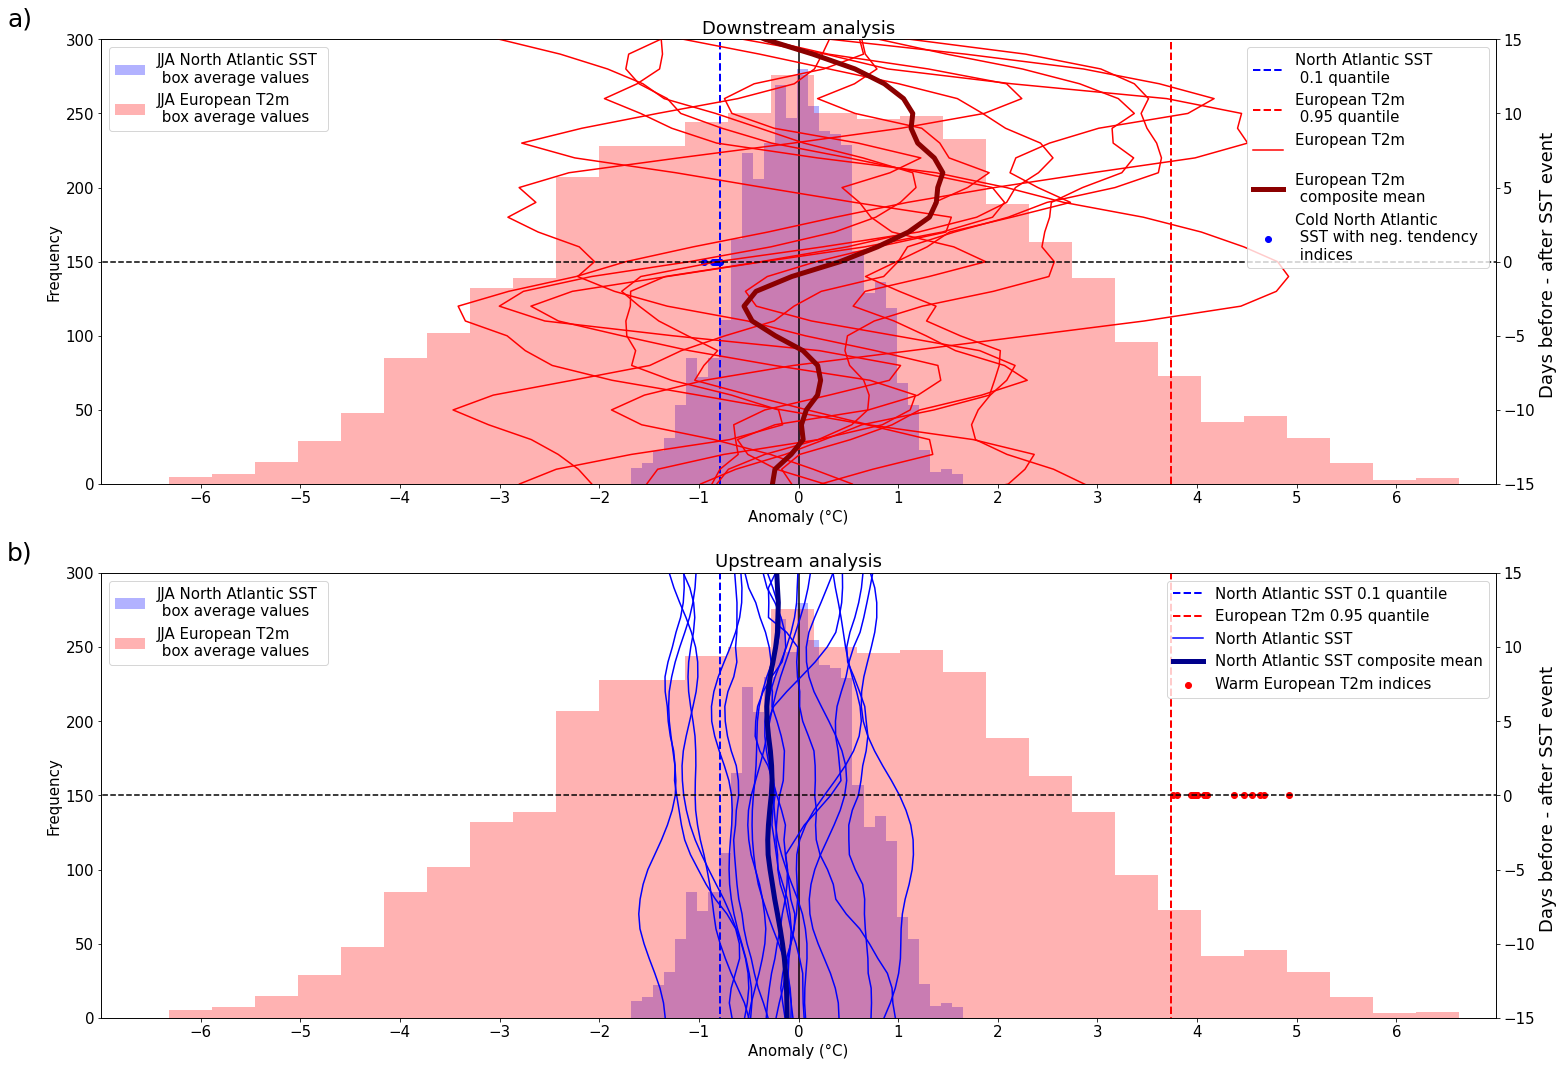

In [11]:
# Set general font size
plt.rcParams['font.size'] = '15'

fig = plt.figure(figsize=(25,18))
axs=[]
for i in range(1,3):
        axs.append(fig.add_subplot(2,1,i))
######## Downstream analysis        
n, bins,patches= axs[0].hist(sst_deseason_Atl_JJA, color='blue', bins=30, alpha = 0.3, label='JJA North Atlantic SST \n box average values')
n, bins,patches= axs[0].hist(t2m_deseason_Euro_JJA_wrm, color='red', bins=30, alpha = 0.3, label='JJA European T2m \n box average values')
axs[0].plot([0,0],[0,300], color='black')
axs[0].set_ylim([0,300])
#plt.xlim([-1,-0.75])
quantile10= -0.78357854
axs[0].set_xticks([-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6])

#df=ds_downstream_analysis.sst_t2m_Euro_line_wtm_downstream.sel(lead_lag=slice(lag,lag)).squeeze()
#dy=[105,115,105,90,115,80,90,105,80,80,90,105]
#dates_t2m =df.time.dt.strftime("%d/%m/%Y")
#for i in range(0,len(dates_t2m)):
#    axs[0].text(df[i],dy[i],dates_t2m.values[i], fontsize=12, horizontalalignment='center', verticalalignment='bottom')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Downstream analysis')
axs[0].set_xlabel('Anomaly (°C)')
axs[0].set_xlim([-7,7])

axs[0].legend(loc=2)

#### Second y axis
axs2_1=axs[0].twinx()
axs2_1.plot([quantile10, quantile10],[-300,300], color='blue', ls='--', lw=2,label='North Atlantic SST \n 0.1 quantile')
axs2_1.plot([quantile_90, quantile_90],[-300,300], color='red', ls='--', lw=2,label='European T2m  \n 0.95 quantile')
#lag=-5
#for i in range(0,15):
#    if i==0:
#        axs2_1.scatter(ds_downstream_analysis.sst_t2m_Euro_line_wtm_downstream.sel(lead_lag=slice(lag+i,lag+i)).squeeze(),np.full((11), lag+i), color='red', label='European T2M ')
#    else:
#        axs2_1.scatter(ds_downstream_analysis.sst_t2m_Euro_line_wtm_downstream.sel(lead_lag=slice(lag+i,lag+i)).squeeze(),np.full((11), lag+i), color='red')
for i in range(0,12):
    if i==0:
        axs2_1.plot(ds_downstream_analysis.sst_t2m_Euro_line_wtm_downstream[:,i].squeeze(),ds_downstream_analysis.sst_t2m_Euro_line_wtm_downstream.lead_lag, color='red', label='European T2m \n')
    else:
        axs2_1.plot(ds_downstream_analysis.sst_t2m_Euro_line_wtm_downstream[:,i].squeeze(),ds_downstream_analysis.sst_t2m_Euro_line_wtm_downstream.lead_lag, color='red')


axs2_1.plot(ds_downstream_analysis.sst_t2m_Euro_line_wtm_downstream.mean('time').squeeze(),ds_downstream_analysis.sst_t2m_Euro_line_wtm_downstream.lead_lag, color='darkred', lw=5, label='European T2m \n composite mean')
axs2_1.scatter(ds_downstream_analysis.sst_deseason_Atl_JJA_lag0_10_concat_downstream,np.full((12), 0), label='Cold North Atlantic \n SST with neg. tendency \n indices', color='blue')
axs2_1.set_yticks([-15,-10,-5,0,5,10,15])
axs2_1.set_ylim([-15,15])
axs2_1.set_ylabel('Days before - after SST event ', fontsize=18)
axs2_1.plot([-10,10],[0,0], color='black', ls='--')
axs2_1.legend(loc=1)

##### Histograms for composites
# for SST between -2 and +2
#sst_comb= [ds_downstream_analysis.sst_t2m_Atl_line_wtm_downstream.sel(lead_lag=slice(-2,-2)).squeeze(),ds_downstream_analysis.sst_t2m_Atl_line_wtm_downstream.sel(lead_lag=slice(-1,-1)).squeeze(),ds_downstream_analysis.sst_t2m_Atl_line_wtm_downstream.sel(lead_lag=slice(0,0)).squeeze(),ds_downstream_analysis.sst_t2m_Atl_line_wtm_downstream.sel(lead_lag=slice(1,1)).squeeze(),ds_downstream_analysis.sst_t2m_Atl_line_wtm_downstream.sel(lead_lag=slice(2,2)).squeeze()]
#sst_cat = xr.concat(sst_comb, dim='time')
# for T2M between -2 and +7
#t2m_comb= [ds_downstream_analysis.sst_t2m_Euro_line_wtm_downstream.sel(lead_lag=slice(2,2)).squeeze(),ds_downstream_analysis.sst_t2m_Euro_line_wtm_downstream.sel(lead_lag=slice(3,3)).squeeze(),ds_downstream_analysis.sst_t2m_Euro_line_wtm_downstream.sel(lead_lag=slice(4,4)).squeeze(),ds_downstream_analysis.sst_t2m_Euro_line_wtm_downstream.sel(lead_lag=slice(5,5)).squeeze(),ds_downstream_analysis.sst_t2m_Euro_line_wtm_downstream.sel(lead_lag=slice(6,6)).squeeze(),ds_downstream_analysis.sst_t2m_Euro_line_wtm_downstream.sel(lead_lag=slice(7,7)).squeeze()]
#t2m_cat = xr.concat(t2m_comb, dim='time')
#axs[0].hist(sst_cat, bins=10, color='blue')
#axs[0].hist(t2m_cat, bins=20, color='red')


######### Upstream analysis
n, bins,patches= axs[1].hist(sst_deseason_Atl_JJA, color='blue', bins=30, alpha = 0.3, label='JJA North Atlantic SST \n box average values')
n, bins,patches= axs[1].hist(t2m_deseason_Euro_JJA_wrm, color='red', bins=30, alpha = 0.3, label='JJA European T2m \n box average values')
axs[1].plot([0,0],[0,300], color='black')
axs[1].set_xlim([-7,7])
axs[1].set_ylim([0,300])
axs[1].set_xlabel('Anomaly (°C)')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Upstream analysis')

#plt.xlim([-1,-0.75])

axs[1].set_xticks([-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6])
lag = -3
df=sst_t2m_Atl_line_wtm[1].sel(lead_lag=slice(lag,lag)).squeeze()
dy=[105,135,70,60,125,125,90,145,80,145,90,115,70,80,115,135,80,105]
dates_sst =df.time.dt.strftime("%d/%m/%Y")
#for i in range(0,len(dates_sst)):
#    axs[1].text(df[i],dy[i],dates_sst.values[i], fontsize=12, horizontalalignment='center', verticalalignment='bottom')
axs[1].legend(loc=2)

#### Second y axis
axs2_2=axs[1].twinx()
axs2_2.plot([quantile10, quantile10],[-300,300], color='blue',lw=2, ls='--',label='North Atlantic SST 0.1 quantile')
axs2_2.plot([quantile_90, quantile_90],[-300,300], color='red', ls='--',lw=2,label='European T2m 0.95 quantile')
#lag=-5
#for i in range(0,15):
#    if i==0:
#        axs2_2.scatter(sst_t2m_Atl_line_wtm[1].sel(lead_lag=slice(lag+i,lag+i)).squeeze(),np.full((17), lag+i), color='blue', label='North Atlantic SST')
#   else:
#        axs2_2.scatter(sst_t2m_Atl_line_wtm[1].sel(lead_lag=slice(lag+i,lag+i)).squeeze(),np.full((17), lag+i), color='blue')
 
for i in range(0,len(sst_t2m_Atl_line_wtm[1].time)):
    if i==0:
        axs2_2.plot(sst_t2m_Atl_line_wtm[1][:,i].squeeze(),sst_t2m_Atl_line_wtm[1][:,i].lead_lag, color='blue', label='North Atlantic SST')
    else:
        axs2_2.plot(sst_t2m_Atl_line_wtm[1][:,i].squeeze(),sst_t2m_Atl_line_wtm[1][:,i].lead_lag, color='blue')

        
axs2_2.plot(sst_t2m_Atl_line_wtm[1].mean('time').squeeze(),sst_t2m_Atl_line_wtm[1].lead_lag, color='darkblue', lw=5, label='North Atlantic SST composite mean')
axs2_2.scatter(t2m_deseason_Euro_JJA_lag0_90_concat,np.full((len(t2m_deseason_Euro_JJA_lag0_90_concat.time)), 0), color='red', label='Warm European T2m indices')
axs2_2.legend(loc=1)
axs2_1.set_yticks([-15,-10,-5,0,5,10,15])
axs2_2.set_ylabel('Days before - after SST event ', fontsize=18)
axs2_2.set_ylim([-15,15])
axs2_2.plot([-10,10],[0,0], color='black', ls='--')

##### Histograms for composites
# for SST between -2 and +2
#sst_comb= [sst_t2m_Atl_line_wtm[1].sel(lead_lag=slice(-5,-5)).squeeze(),sst_t2m_Atl_line_wtm[1].sel(lead_lag=slice(-4,-4)).squeeze(),sst_t2m_Atl_line_wtm[1].sel(lead_lag=slice(-3,-3)).squeeze(),sst_t2m_Atl_line_wtm[1].sel(lead_lag=slice(-2,-2)).squeeze(),sst_t2m_Atl_line_wtm[1].sel(lead_lag=slice(-1,-1)).squeeze()]
#sst_cat = xr.concat(sst_comb, dim='time')
# for T2M between -2 and +7
#t2m_comb= [sst_t2m_Euro_line_wtm[1].sel(lead_lag=slice(0,0)).squeeze(),sst_t2m_Euro_line_wtm[1].sel(lead_lag=slice(1,1)).squeeze(),sst_t2m_Euro_line_wtm[1].sel(lead_lag=slice(2,2)).squeeze(),sst_t2m_Euro_line_wtm[1].sel(lead_lag=slice(3,3)).squeeze(),sst_t2m_Euro_line_wtm[1].sel(lead_lag=slice(4,4)).squeeze(),sst_t2m_Euro_line_wtm[1].sel(lead_lag=slice(5,5)).squeeze()]
#t2m_cat = xr.concat(t2m_comb, dim='time')
#axs[1].hist(sst_cat, bins=10, color='blue')
#axs[1].hist(t2m_cat, bins=20, color='red')
plt.figtext(0.08,0.905,"a)", ha="center", va="top", fontsize=25)
plt.figtext(0.08,0.4925,"b)", ha="center", va="top", fontsize=25)
plt.savefig('ERA5_NA_SST_Euro_T2M_upstream_downstream_distrib_analysis_3consec_days_12_18.pdf')

# Plot Distribution of all SST and T2M JJA values (3772) and cold SST & warm T2M composite dates

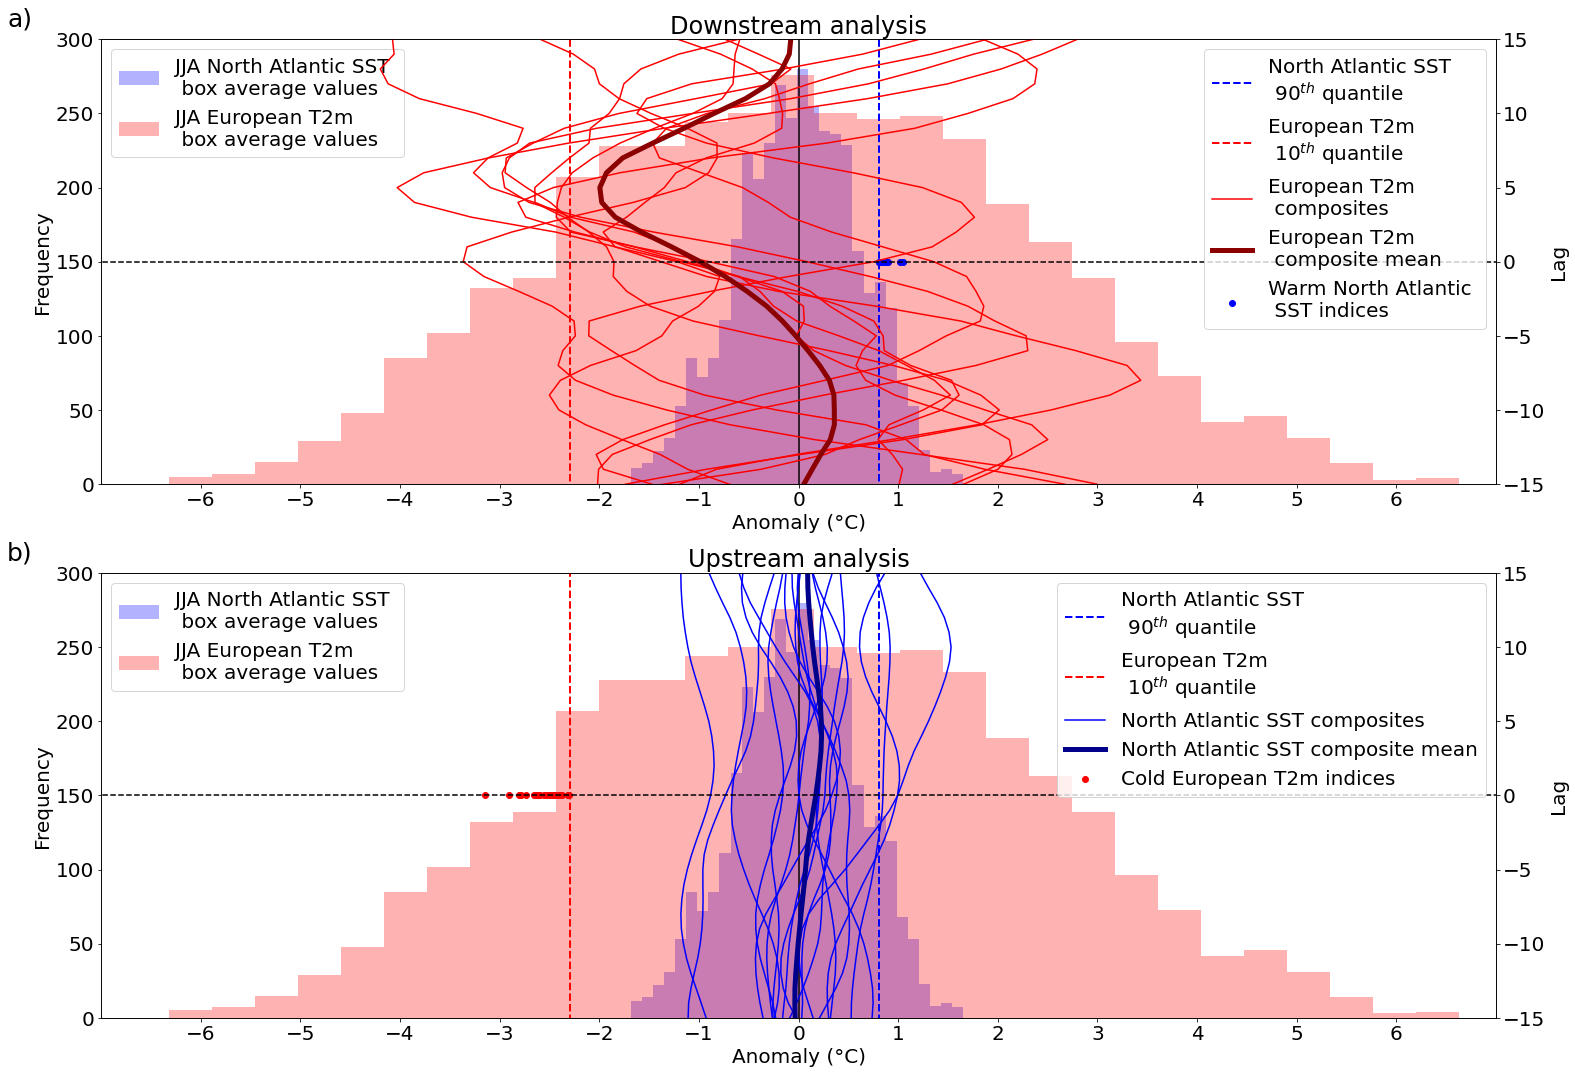

In [13]:
fig = plt.figure(figsize=(25,18))
axs=[]
for i in range(1,3):
        axs.append(fig.add_subplot(2,1,i))
######## Downstream analysis        
n, bins,patches= axs[0].hist(sst_deseason_Atl_JJA, color='blue', bins=30, alpha = 0.3, label='JJA North Atlantic SST \n box average values')
n, bins,patches= axs[0].hist(t2m_deseason_Euro_JJA_wrm, color='red', bins=30, alpha = 0.3, label='JJA European T2m \n box average values')
axs[0].plot([0,0],[0,300], color='black')
axs[0].set_ylim([0,300])
#plt.xlim([-1,-0.75])
quantile90= 0.80281801
axs[0].set_xticks([-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6])

df=ds_downstream_analysis_warm_comp.sst_t2m_Euro_line_wtm_downstream_warm.sel(lead_lag=slice(lag,lag)).squeeze()
dy=[105,115,105,90,115,80,90,105,80,80,90,105]
dates_t2m =df.time.dt.strftime("%d/%m/%Y")
#for i in range(0,len(dates_t2m)):
#    axs[0].text(df[i],dy[i],dates_t2m.values[i], fontsize=12, horizontalalignment='center', verticalalignment='bottom')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Downstream analysis')
axs[0].set_xlabel('Anomaly (°C)')
axs[0].set_xlim([-7,7])

axs[0].legend(loc=2)

#### Second y axis
axs2_1=axs[0].twinx()
axs2_1.plot([quantile90, quantile90],[-300,300], color='blue', ls='--', lw=2,label='North Atlantic SST \n 90$^{th}$ quantile')
axs2_1.plot([quantile_10, quantile_10],[-300,300], color='red', ls='--', lw=2,label='European T2m  \n 10$^{th}$ quantile')
#lag=-5
#for i in range(0,15):
#    if i==0:
#        axs2_1.scatter(ds_downstream_analysis.sst_t2m_Euro_line_wtm_downstream.sel(lead_lag=slice(lag+i,lag+i)).squeeze(),np.full((11), lag+i), color='red', label='European T2M ')
#    else:
#        axs2_1.scatter(ds_downstream_analysis.sst_t2m_Euro_line_wtm_downstream.sel(lead_lag=slice(lag+i,lag+i)).squeeze(),np.full((11), lag+i), color='red')
for i in range(0,11):
    if i==0:
        axs2_1.plot(ds_downstream_analysis_warm_comp.sst_t2m_Euro_line_wtm_downstream_warm[:,i].squeeze(),ds_downstream_analysis_warm_comp.sst_t2m_Euro_line_wtm_downstream_warm.lead_lag, color='red', label='European T2m \n composites ')
    else:
        axs2_1.plot(ds_downstream_analysis_warm_comp.sst_t2m_Euro_line_wtm_downstream_warm[:,i].squeeze(),ds_downstream_analysis_warm_comp.sst_t2m_Euro_line_wtm_downstream_warm.lead_lag, color='red')


axs2_1.plot(ds_downstream_analysis_warm_comp.sst_t2m_Euro_line_wtm_downstream_warm.mean('time').squeeze(),ds_downstream_analysis.sst_t2m_Euro_line_wtm_downstream.lead_lag, color='darkred', lw=5, label='European T2m \n composite mean')
axs2_1.scatter(ds_downstream_analysis_warm_comp.sst_deseason_Atl_JJA_lag0_90_concat_downstream,np.full((13), 0), label='Warm North Atlantic \n SST indices', color='blue')
axs2_1.set_yticks([-15,-10,-5,0,5,10,15])
axs2_1.set_ylim([-15,15])
axs2_1.set_ylabel('Lag')
axs2_1.plot([-10,10],[0,0], color='black', ls='--')
axs2_1.legend(loc=1)

##### Histograms for composites
# for SST between -2 and +2
#sst_comb= [ds_downstream_analysis.sst_t2m_Atl_line_wtm_downstream.sel(lead_lag=slice(-2,-2)).squeeze(),ds_downstream_analysis.sst_t2m_Atl_line_wtm_downstream.sel(lead_lag=slice(-1,-1)).squeeze(),ds_downstream_analysis.sst_t2m_Atl_line_wtm_downstream.sel(lead_lag=slice(0,0)).squeeze(),ds_downstream_analysis.sst_t2m_Atl_line_wtm_downstream.sel(lead_lag=slice(1,1)).squeeze(),ds_downstream_analysis.sst_t2m_Atl_line_wtm_downstream.sel(lead_lag=slice(2,2)).squeeze()]
#sst_cat = xr.concat(sst_comb, dim='time')
# for T2M between -2 and +7
#t2m_comb= [ds_downstream_analysis.sst_t2m_Euro_line_wtm_downstream.sel(lead_lag=slice(2,2)).squeeze(),ds_downstream_analysis.sst_t2m_Euro_line_wtm_downstream.sel(lead_lag=slice(3,3)).squeeze(),ds_downstream_analysis.sst_t2m_Euro_line_wtm_downstream.sel(lead_lag=slice(4,4)).squeeze(),ds_downstream_analysis.sst_t2m_Euro_line_wtm_downstream.sel(lead_lag=slice(5,5)).squeeze(),ds_downstream_analysis.sst_t2m_Euro_line_wtm_downstream.sel(lead_lag=slice(6,6)).squeeze(),ds_downstream_analysis.sst_t2m_Euro_line_wtm_downstream.sel(lead_lag=slice(7,7)).squeeze()]
#t2m_cat = xr.concat(t2m_comb, dim='time')
#axs[0].hist(sst_cat, bins=10, color='blue')
#axs[0].hist(t2m_cat, bins=20, color='red')


######### Upstream analysis
n, bins,patches= axs[1].hist(sst_deseason_Atl_JJA, color='blue', bins=30, alpha = 0.3, label='JJA North Atlantic SST \n box average values')
n, bins,patches= axs[1].hist(t2m_deseason_Euro_JJA_wrm, color='red', bins=30, alpha = 0.3, label='JJA European T2m \n box average values')
axs[1].plot([0,0],[0,300], color='black')
axs[1].set_xlim([-7,7])
axs[1].set_ylim([0,300])
axs[1].set_xlabel('Anomaly (°C)')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Upstream analysis')

#plt.xlim([-1,-0.75])

axs[1].set_xticks([-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6])
lag=-3
df=sst_t2m_Atl_line_wtm[0].sel(lead_lag=slice(lag,lag)).squeeze()
dy=[105,135,70,60,125,125,90,145,80,145,90,115,70,80,115,135,80,105]
dates_sst =df.time.dt.strftime("%d/%m/%Y")
#for i in range(0,len(dates_sst)):
#    axs[1].text(df[i],dy[i],dates_sst.values[i], fontsize=12, horizontalalignment='center', verticalalignment='bottom')
axs[1].legend(loc=2)

#### Second y axis
axs2_2=axs[1].twinx()
axs2_2.plot([quantile90, quantile90],[-300,300], color='blue',lw=2, ls='--',label='North Atlantic SST \n 90$^{th}$ quantile')
axs2_2.plot([quantile_10, quantile_10],[-300,300], color='red', ls='--',lw=2,label='European T2m \n 10$^{th}$ quantile')
#lag=-5
#for i in range(0,15):
#    if i==0:
#        axs2_2.scatter(sst_t2m_Atl_line_wtm[1].sel(lead_lag=slice(lag+i,lag+i)).squeeze(),np.full((17), lag+i), color='blue', label='North Atlantic SST')
#   else:
#        axs2_2.scatter(sst_t2m_Atl_line_wtm[1].sel(lead_lag=slice(lag+i,lag+i)).squeeze(),np.full((17), lag+i), color='blue')
 
for i in range(0,len(sst_t2m_Atl_line_wtm[1].time)):
    if i==0:
        axs2_2.plot(sst_t2m_Atl_line_wtm[0][:,i].squeeze(),sst_t2m_Atl_line_wtm[0][:,i].lead_lag, color='blue', label='North Atlantic SST composites')
    else:
        axs2_2.plot(sst_t2m_Atl_line_wtm[0][:,i].squeeze(),sst_t2m_Atl_line_wtm[0][:,i].lead_lag, color='blue')

        
axs2_2.plot(sst_t2m_Atl_line_wtm[0].mean('time').squeeze(),sst_t2m_Atl_line_wtm[0].lead_lag, color='darkblue', lw=5, label='North Atlantic SST composite mean')
axs2_2.scatter(t2m_deseason_Euro_JJA_lag0_10_concat,np.full((len(t2m_deseason_Euro_JJA_lag0_10_concat.time)), 0), color='red', label='Cold European T2m indices')
axs2_2.legend(loc=1)
axs2_1.set_yticks([-15,-10,-5,0,5,10,15])
axs2_2.set_ylabel('Lag')
axs2_2.set_ylim([-15,15])
axs2_2.plot([-10,10],[0,0], color='black', ls='--')

##### Histograms for composites
# for SST between -2 and +2
#sst_comb= [sst_t2m_Atl_line_wtm[1].sel(lead_lag=slice(-5,-5)).squeeze(),sst_t2m_Atl_line_wtm[1].sel(lead_lag=slice(-4,-4)).squeeze(),sst_t2m_Atl_line_wtm[1].sel(lead_lag=slice(-3,-3)).squeeze(),sst_t2m_Atl_line_wtm[1].sel(lead_lag=slice(-2,-2)).squeeze(),sst_t2m_Atl_line_wtm[1].sel(lead_lag=slice(-1,-1)).squeeze()]
#sst_cat = xr.concat(sst_comb, dim='time')
# for T2M between -2 and +7
#t2m_comb= [sst_t2m_Euro_line_wtm[1].sel(lead_lag=slice(0,0)).squeeze(),sst_t2m_Euro_line_wtm[1].sel(lead_lag=slice(1,1)).squeeze(),sst_t2m_Euro_line_wtm[1].sel(lead_lag=slice(2,2)).squeeze(),sst_t2m_Euro_line_wtm[1].sel(lead_lag=slice(3,3)).squeeze(),sst_t2m_Euro_line_wtm[1].sel(lead_lag=slice(4,4)).squeeze(),sst_t2m_Euro_line_wtm[1].sel(lead_lag=slice(5,5)).squeeze()]
#t2m_cat = xr.concat(t2m_comb, dim='time')
#axs[1].hist(sst_cat, bins=10, color='blue')
#axs[1].hist(t2m_cat, bins=20, color='red')
plt.figtext(0.08,0.905,"a)", ha="center", va="top", fontsize=25)
plt.figtext(0.08,0.4925,"b)", ha="center", va="top", fontsize=25)
plt.savefig('ERA5_NA_SST_Euro_T2M_upstream_downstream_distrubtion_analysis_warm_composite.pdf')

# Calculate and plot number of 39 events with neg. tendency and show their sign domain 

<xarray.DataArray (lead_lag: 117, time: 18)>
array([[-0.23569056, -0.49899307, -0.65328455, ..., -0.3525104 ,
        -0.03156294, -0.6942722 ],
       [-0.2385165 , -0.48285165, -0.63442916, ..., -0.37586835,
        -0.00606543, -0.7232779 ],
       [-0.23499034, -0.47724122, -0.6273175 , ..., -0.37193686,
         0.00256023, -0.71938455],
       ...,
       [-0.08628888, -0.7598372 , -1.0469761 , ..., -0.7461901 ,
        -0.6067534 ,  0.048676  ],
       [-0.21929921, -0.647433  , -1.0483456 , ..., -0.72409564,
        -0.5740546 ,  0.01664453],
       [-0.3241654 , -0.5381879 , -1.0404199 , ..., -0.69982326,
        -0.5533636 , -0.00473074]], dtype=float32)
Coordinates:
  * lead_lag  (lead_lag) int64 -58 -57 -56 -55 -54 -53 -52 ... 53 54 55 56 57 58
  * time      (time) datetime64[ns] 1983-07-09T06:00:00 ... 2019-06-24T06:00:00
<xarray.DataArray (lead_lag: 117)>
array([ 0.,  8., 10., 10.,  9.,  9.,  8.,  9., 11., 10., 11.,  6.,  8.,
        8.,  7.,  5.,  9.,  8.,  8.,  7., 10.,

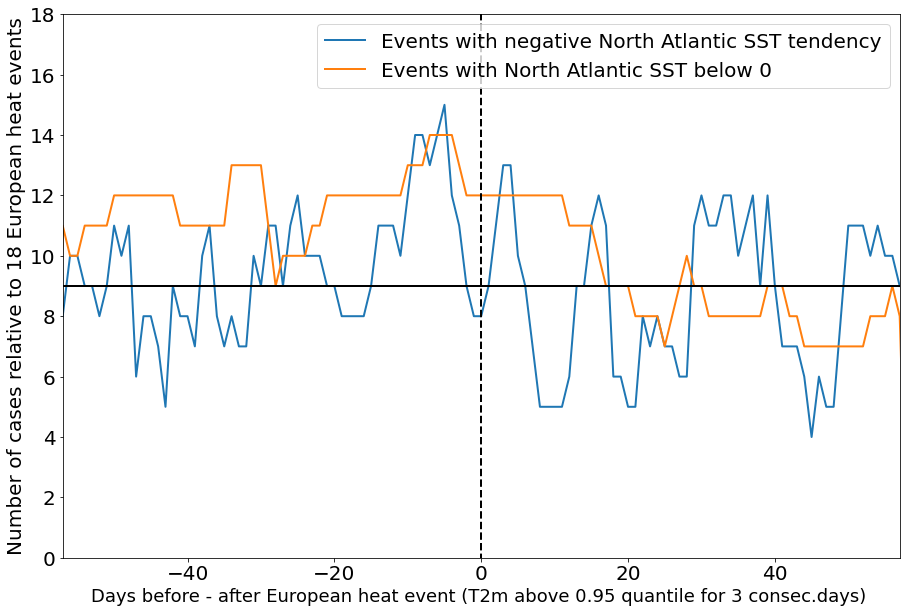

In [17]:
print(sst_t2m_Atl_line_wtm[1])

sst_Atl_line_neg_tend_lag = xr.DataArray(np.zeros((len(sst_t2m_Atl_line_wtm[1].lead_lag), len(sst_t2m_Atl_line_wtm[1].time))),dims=["lead_lag", "time"],coords=dict(lead_lag=sst_t2m_Atl_line_wtm[1].lead_lag, time=sst_t2m_Atl_line_wtm[1].time))
sst_Atl_line_neg_lag = xr.DataArray(np.zeros((len(sst_t2m_Atl_line_wtm[1].lead_lag), len(sst_t2m_Atl_line_wtm[1].time))),dims=["lead_lag", "time"],coords=dict(lead_lag=sst_t2m_Atl_line_wtm[1].lead_lag, time=sst_t2m_Atl_line_wtm[1].time))

for l in range(1,len(sst_t2m_Atl_line_wtm[1].lead_lag)-1):
    for e in range(len(sst_t2m_Atl_line_wtm[1].time)):
        if (sst_t2m_Atl_line_wtm[1][l-1,e] + sst_t2m_Atl_line_wtm[1][l,e])/2 > (sst_t2m_Atl_line_wtm[1][l,e] + sst_t2m_Atl_line_wtm[1][l+1,e])/2:
            sst_Atl_line_neg_tend_lag[l,e] +=1
        if sst_t2m_Atl_line_wtm[1][l,e] < 0:
            sst_Atl_line_neg_lag[l,e] +=1
sst_Atl_line_neg_tend_lag_sum = sst_Atl_line_neg_tend_lag.sum(dim='time')
sst_Atl_line_neg_lag_sum = sst_Atl_line_neg_lag.sum(dim='time')
print(sst_Atl_line_neg_tend_lag_sum)

#######Plot
# Set general font size
plt.rcParams['font.size'] = '20'
fig = plt.figure(figsize=(15,10))
plt.plot(sst_Atl_line_neg_tend_lag_sum.lead_lag[1:-1], sst_Atl_line_neg_tend_lag_sum[1:-1], label ='Events with negative North Atlantic SST tendency', lw=2)
plt.plot(sst_Atl_line_neg_tend_lag_sum.lead_lag, sst_Atl_line_neg_lag_sum, label ='Events with North Atlantic SST below 0', lw=2)
plt.plot([-60,60], [len(sst_t2m_Atl_line_wtm[1].time)/2,len(sst_t2m_Atl_line_wtm[1].time)/2], color = 'black', lw=2)
plt.plot([0,0],[-130,130], color='black', ls='--', lw=2)

plt.legend()
plt.xlabel('Days before - after European heat event (T2m above 0.95 quantile for 3 consec.days) ', fontsize=18)
plt.ylabel('Number of cases relative to 18 European heat events')

plt.xlim([-57,57])
plt.ylim([0,18])
plt.savefig('ERA5_NA_SST_Euro_T2M_upstream_distrubtion_analysis_cold_SSTs_neg_tend_number.pdf')
#plt.yticks([0,2,4,6,8,10,12,14,16,18])
#rasterize_list = [fig]
#raster.rasterize_and_save('ERA5_upstream_analysis_events_with_neg_tendency_10_quant_4_consec_days_25.pdf', rasterize_list, dpi=300)